<a href="https://colab.research.google.com/github/meti-94/TextClassification/blob/main/FinRL_BTC_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: BTC Trading

* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)   
* [RLlib Section](#7)            

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of BTC" or "Sell 10 shares of BTC" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: BTC/USD


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git -q

     |████████████████████████████████| 234 kB 8.2 MB/s 
     |████████████████████████████████| 176 kB 38.9 MB/s 
     |████████████████████████████████| 57.6 MB 1.4 MB/s 
     |████████████████████████████████| 1.8 MB 35.2 MB/s 
     |████████████████████████████████| 124 kB 42.7 MB/s 
     |████████████████████████████████| 147 kB 47.7 MB/s 
     |████████████████████████████████| 45 kB 3.2 MB/s 
     |████████████████████████████████| 2.4 MB 39.9 MB/s 
     |████████████████████████████████| 153 kB 55.0 MB/s 
     |████████████████████████████████| 195 kB 49.0 MB/s 
     |████████████████████████████████| 90.8 MB 310 bytes/s 
     |████████████████████████████████| 448 kB 48.6 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 1.1 MB 43.7 MB/s 
     |████████████████████████████████| 3.6 MB 31.7 MB/s 
     |████████████████████████████████| 271 kB 51.3 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████

In [3]:
from finrl.apps import config
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
# from config.py start_date is a string
config.START_DATE = '2015-01-01'
config.START_DATE

'2015-01-01'

In [6]:
# from config.py end_date is a string
config.END_DATE = '2022-01-01'
config.END_DATE

'2022-01-01'

In [7]:
config.DOW_30_TICKER = ['BTC']
config.DOW_30_TICKER

['BTC']

In [38]:
df = YahooDownloader(start_date = config.START_DATE,
                     end_date = config.END_DATE,
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (316, 8)


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    316 non-null    object 
 1   open    316 non-null    float64
 2   high    316 non-null    float64
 3   low     316 non-null    float64
 4   close   316 non-null    float64
 5   volume  316 non-null    int64  
 6   tic     316 non-null    object 
 7   day     316 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 19.9+ KB


In [9]:
list(df.columns)

['date', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day']

In [10]:
print(config.DOW_30_TICKER)

['BTC']


In [11]:
df.shape

(316, 8)

In [12]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2020-10-01,100.000000,100.000000,100.000000,100.000000,0,BTC,3
1,2020-10-02,100.000000,100.000000,100.000000,100.000000,0,BTC,4
2,2020-10-05,100.029999,100.040001,99.995003,99.995003,10725,BTC,0
3,2020-10-06,100.010002,100.029999,100.010002,100.029999,10080,BTC,1
4,2020-10-07,99.949997,99.959999,99.919998,99.919998,6350,BTC,2


In [16]:
df.info

<bound method DataFrame.info of            date        open        high  ...  volume  tic  day
0    2020-10-01  100.000000  100.000000  ...       0  BTC    3
1    2020-10-02  100.000000  100.000000  ...       0  BTC    4
2    2020-10-05  100.029999  100.040001  ...   10725  BTC    0
3    2020-10-06  100.010002  100.029999  ...   10080  BTC    1
4    2020-10-07   99.949997   99.959999  ...    6350  BTC    2
..          ...         ...         ...  ...     ...  ...  ...
311  2021-12-27   98.540001   98.550003  ...    2513  BTC    0
312  2021-12-28   98.610001   98.610001  ...     160  BTC    1
313  2021-12-29   98.470001   98.485001  ...     402  BTC    2
314  2021-12-30   98.609497   98.609497  ...      83  BTC    3
315  2021-12-31   98.584999   98.584999  ...       5  BTC    4

[316 rows x 8 columns]>

In [ ]:
!pip install kaggle -q

import os
os.environ['KAGGLE_CONFIG_DIR']='/content/drive/MyDrive/kaggle_dataset'
%cd /content/drive/MyDrive/kaggle_dataset
!kaggle datasets download -d mczielinski/bitcoin-historical-data
!unzip bitcoin-historical-data.zip

In [40]:
def read_data(path):
    hist = pd.read_csv(path, parse_dates=True)
    hist = hist[hist.Timestamp>=1388521800]
    hist['date'] = hist['Timestamp'].apply(lambda item:datetime.fromtimestamp(item))
    hist.set_index('date', inplace=True)
    hist.dropna(inplace=True)
    return hist

def resampling(hist, timeframe='1min'):
    ohlc = {
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume_(BTC)':'sum'
    }
    df = hist.resample(timeframe, origin='end_day').apply(ohlc)
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df.rename(columns={'Open':'open', 'High':'high', 'Close':'close', 'Low':'low', 'Volume_(BTC)':'volume'}, inplace=True)
    df['date'] = df['date'].astype(str)
    df['tic'] = ['BTC' for _ in range(len(df))]
    df['day'] = [i%5 for i in range(len(df))]
    return df   

In [41]:
hist = read_data('/content/drive/MyDrive/kaggle_dataset/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
hist = hist['2014-01-01' :'2021-03-30']
hist = resampling(hist, timeframe='D')
df = hist

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2644 non-null   object 
 1   open    2644 non-null   float64
 2   high    2644 non-null   float64
 3   low     2644 non-null   float64
 4   close   2644 non-null   float64
 5   volume  2644 non-null   float64
 6   tic     2644 non-null   object 
 7   day     2644 non-null   int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 165.4+ KB


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [43]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1823, 8)
Successfully added vix
Successfully added turbulence index


In [44]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [45]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2014-01-02,BTC,732.01,757.99,729.01,754.90,7903.038301,1.0,0.513782,775.835491,711.064509,100.000000,66.666667,100.000000,743.450000,743.450000,14.23,0.0
1,2014-01-03,BTC,751.88,798.70,742.50,784.19,15134.172831,2.0,1.562941,809.350233,704.709767,100.000000,100.000000,100.000000,757.030000,757.030000,13.76,0.0
2,2014-01-06,BTC,828.83,948.00,826.07,905.00,24067.042492,0.0,8.400712,925.084076,679.689257,100.000000,156.587191,100.000000,802.386667,802.386667,13.55,0.0
3,2014-01-07,BTC,905.23,995.00,876.00,915.56,25901.389228,1.0,11.327710,959.495829,677.612742,100.000000,135.731314,100.000000,818.554286,818.554286,12.92,0.0
4,2014-01-08,BTC,915.56,943.00,780.00,780.00,34154.459703,2.0,6.661009,947.038964,680.431036,54.800819,23.683737,38.925707,813.735000,813.735000,12.87,0.0
5,2014-01-09,BTC,784.50,849.79,765.00,823.95,26210.364808,3.0,5.508577,939.750261,689.989739,60.750757,-3.530812,32.183687,814.870000,814.870000,12.89,0.0
6,2014-01-10,BTC,823.95,848.00,779.78,824.76,25299.469800,4.0,4.652651,933.763274,697.954726,60.849016,2.995430,32.183687,815.859000,815.859000,12.14,0.0
7,2014-01-13,BTC,894.70,905.00,826.46,841.52,12159.345801,2.0,7.168749,938.603016,714.432369,59.421119,49.184608,34.799890,826.517692,826.517692,13.28,0.0
8,2014-01-14,BTC,841.52,843.60,783.11,824.00,19363.714080,3.0,5.327803,934.034362,718.641353,56.898773,-13.546430,17.604009,826.337857,826.337857,12.28,0.0
9,2014-01-15,BTC,824.00,837.00,800.00,815.99,9730.124914,4.0,3.396149,929.564429,721.731571,55.778933,-12.171596,17.604009,825.648000,825.648000,12.28,0.0


In [46]:
processed_full.sort_values(['date','tic'],ignore_index=True).tail(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
1810,2021-03-17,BTC,55413.23,57150.00,53221.00,57127.98,7720.773149,4.0,3051.346731,61837.691982,42297.886018,61.113118,74.526036,14.449061,52161.940667,44871.618000,19.230000,0.207861
1811,2021-03-18,BTC,57079.16,59244.98,54124.00,59244.98,5854.798012,0.0,3129.511848,62643.039136,42720.536864,62.716614,97.604003,21.156922,52540.721000,45261.045167,21.580000,0.330618
1812,2021-03-19,BTC,59235.60,60083.25,57000.00,57524.96,5493.120625,1.0,3017.878798,62954.826429,43528.437571,60.615805,100.927726,23.715298,52816.865667,45621.242667,20.950001,0.748917
1813,2021-03-22,BTC,58038.65,58632.52,55500.00,57425.64,3627.440501,4.0,2680.504472,63206.317638,46523.724362,60.232799,66.745163,10.349283,53267.170333,46711.766833,18.879999,0.070404
1814,2021-03-23,BTC,57393.65,58461.78,53715.00,54262.78,6570.362893,0.0,2275.173323,62932.360532,47386.578468,56.349489,39.695376,2.396768,53210.667667,47105.283833,20.299999,2.076739
1815,2021-03-24,BTC,54249.05,55866.44,52933.03,54233.85,5001.192174,1.0,1929.370477,62791.824452,47932.868548,56.315135,23.444063,0.946121,53099.929667,47461.071500,21.200001,0.053881
1816,2021-03-25,BTC,54267.89,57207.33,51638.76,52349.40,6874.214748,2.0,1486.128697,62381.194383,48747.271617,54.092872,12.938777,4.753569,53039.933333,47800.005833,19.809999,0.991900
1817,2021-03-26,BTC,52291.72,53271.59,50360.00,51355.59,6668.912147,3.0,1042.645266,62072.803038,49301.593962,52.952880,-22.605052,0.947877,53119.601333,48118.446000,18.860001,0.401307
1818,2021-03-29,BTC,55946.79,56573.04,54677.51,55804.36,2074.410637,1.0,981.075478,61125.039038,51711.056962,57.113164,37.272459,12.953798,53915.662333,49316.047833,20.740000,3.051882
1819,2021-03-30,BTC,55822.98,58402.68,54892.42,57670.58,5363.655852,2.0,1104.926211,61240.759938,51861.956062,58.805280,58.878863,19.970756,54305.441667,49719.447000,19.610001,0.290028


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of BTC" or "Sell 10 shares of BTC" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2020-07-01
## Trade data split: 2020-07-01 to 2021-10-31

In [48]:
train = data_split(processed_full, '2014-01-01','2019-12-30')
trade = data_split(processed_full, '2019-12-30','2021-03-30')
print(len(train))
print(len(trade))

1505
314


In [49]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
1500,2019-12-20,BTC,7312.33,7372.12,7000.00,7152.85,5890.150193,1.0,-216.265923,7717.238116,6798.768884,43.565215,-47.098110,17.241634,7312.158000,8056.563333,12.51,0.325071
1501,2019-12-23,BTC,7136.01,7543.27,7124.52,7543.27,3835.810260,4.0,-139.578708,7691.133310,6783.759690,47.646910,55.852805,1.309110,7274.820000,8026.295500,12.61,1.264039
1502,2019-12-24,BTC,7543.27,7692.98,7247.86,7322.70,6665.968354,0.0,-120.652291,7693.103530,6784.140470,45.770106,59.041985,7.937096,7274.353333,8024.343000,12.67,0.527695
1503,2019-12-26,BTC,7255.55,7266.81,7110.73,7189.80,1505.818294,2.0,-105.458895,7681.627364,6783.439636,44.655744,-42.171316,1.135215,7288.348667,7965.316333,12.65,0.230259
1504,2019-12-27,BTC,7189.82,7432.00,7150.00,7187.00,3120.054271,3.0,-100.914876,7636.200714,6791.710286,44.631639,-14.549331,8.864639,7289.552333,7925.613000,13.43,0.007648


In [50]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2019-12-30,BTC,7303.95,7524.46,7274.43,7373.31,2578.586403,1.0,-61.989725,7569.857683,6813.851317,46.686939,60.212815,15.904570,7263.511667,7827.233667,14.82,0.249586
1,2019-12-31,BTC,7374.61,7384.90,7195.35,7195.35,3742.154103,2.0,-62.392237,7568.201796,6812.748204,44.985077,1.254479,11.374963,7251.486667,7794.521500,13.78,0.390196
2,2020-01-02,BTC,7161.51,7237.35,7150.00,7176.23,1114.711226,4.0,-64.704701,7558.033785,6807.954215,44.846302,-31.350803,6.707486,7238.400667,7723.829167,12.47,0.018801
3,2020-01-03,BTC,7169.70,7184.94,6900.00,6946.56,4003.390169,0.0,-82.178475,7556.033975,6779.884025,42.649668,-117.010890,6.772129,7226.646333,7686.106167,14.02,0.631633
4,2020-01-06,BTC,7354.22,7495.00,7310.00,7347.52,2708.293113,3.0,-34.387423,7591.539271,6842.615729,47.322448,86.383978,9.396315,7223.777000,7585.279000,13.85,1.486921


In [51]:
config.TECHNICAL_INDICATORS_LIST

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [52]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 1, State Space: 11


In [53]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [54]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [55]:
agent = DRLAgent(env = env_train)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [56]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [57]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

--------------------------------------
| time/                 |            |
|    fps                | 214        |
|    iterations         | 100        |
|    time_elapsed       | 2          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -1.42      |
|    explained_variance | 0.0867     |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -3.18      |
|    reward             | -1.1828976 |
|    std                | 0.999      |
|    value_loss         | 11.4       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 223        |
|    iterations         | 200        |
|    time_elapsed       | 4          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -1.43      |
|    explained_variance | 0.00236    |
|    learning_rate      |

### Model 2: DDPG

In [58]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [59]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 103       |
|    time_elapsed    | 58        |
|    total_timesteps | 6020      |
| train/             |           |
|    actor_loss      | -2.15e+03 |
|    critic_loss     | 9.27e+03  |
|    learning_rate   | 0.001     |
|    n_updates       | 4515      |
|    reward          | 0.0       |
----------------------------------
day: 1504, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 1000000.00
total_reward: 0.00
total_cost: 0.00
total_trades: 0
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 90        |
|    time_elapsed    | 132       |
|    total_timesteps | 12040     |
| train/             |           |
|    actor_loss      | -1.82e+03 |
|    critic_loss     | 5.09e+03  |
|    learning_rate   | 0.001     |
|    n_updates       | 10535     |
|    reward          | 0.0 

### Model 3: PPO

In [60]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [61]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

-----------------------------------
| time/              |            |
|    fps             | 375        |
|    iterations      | 1          |
|    time_elapsed    | 5          |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | -0.2113903 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 335         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.003184176 |
|    clip_fraction        | 0.0132      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | -0.000104   |
|    learning_rate        | 0.00025     |
|    loss                 | 1.17e+04    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00197    |
|   

### Model 4: TD3

In [62]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device


In [63]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 109      |
|    time_elapsed    | 54       |
|    total_timesteps | 6020     |
| train/             |          |
|    actor_loss      | -262     |
|    critic_loss     | 5.98e+04 |
|    learning_rate   | 0.001    |
|    n_updates       | 4515     |
|    reward          | -0.11928 |
---------------------------------
day: 1504, episode: 110
begin_total_asset: 1000000.00
end_total_asset: 3061668.00
total_reward: 2061668.00
total_cost: 999.00
total_trades: 1504
Sharpe: 0.667
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 98       |
|    time_elapsed    | 122      |
|    total_timesteps | 12040    |
| train/             |          |
|    actor_loss      | -87      |
|    critic_loss     | 9.51e+03 |
|    learning_rate   | 0.001    |
|    n_updates       | 10535    |
|    reward          | -0

### Model 5: SAC

In [64]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [65]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

day: 1504, episode: 130
begin_total_asset: 1000000.00
end_total_asset: 1000000.00
total_reward: 0.00
total_cost: 0.00
total_trades: 0
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 50       |
|    time_elapsed    | 119      |
|    total_timesteps | 6020     |
| train/             |          |
|    actor_loss      | 2.3e+04  |
|    critic_loss     | 2.72e+04 |
|    ent_coef        | 0.181    |
|    ent_coef_loss   | 16.1     |
|    learning_rate   | 0.0001   |
|    n_updates       | 5919     |
|    reward          | 0.0      |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 50       |
|    time_elapsed    | 237      |
|    total_timesteps | 12040    |
| train/             |          |
|    actor_loss      | 1.71e+04 |
|    critic_loss     | 1.56e+03 |
|    ent_coef        | 0.33     |
|    ent_coef_lo

## Trading
Assume that we have $1,000,000 initial capital at 2021-07-01. We use the DDPG model to trade BTC stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [66]:
# train = data_split(processed_full, '2014-01-01','2019-12-30')
# trade = data_split(processed_full, '2019-12-30','2021-03-30')
data_risk_indicator = processed_full[(processed_full.date<'2019-12-30') & (processed_full.date>='2014-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [67]:
insample_risk_indicator.vix.describe()

count    1505.000000
mean       14.961708
std         4.045220
min         9.140000
25%        12.290000
50%        13.950000
75%        16.490000
max        40.740002
Name: vix, dtype: float64

In [68]:
insample_risk_indicator.vix.quantile(0.996)

30.408559844970696

In [69]:
insample_risk_indicator.turbulence.describe()

count    1505.000000
mean        0.928695
std         2.975403
min         0.000000
25%         0.003600
50%         0.095465
75%         0.568596
max        47.316742
Name: turbulence, dtype: float64

In [70]:
insample_risk_indicator.turbulence.quantile(0.996)

23.658840384059832

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [71]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [72]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2019-12-30,BTC,7303.95,7524.46,7274.43,7373.31,2578.586403,1.0,-61.989725,7569.857683,6813.851317,46.686939,60.212815,15.904570,7263.511667,7827.233667,14.82,0.249586
1,2019-12-31,BTC,7374.61,7384.90,7195.35,7195.35,3742.154103,2.0,-62.392237,7568.201796,6812.748204,44.985077,1.254479,11.374963,7251.486667,7794.521500,13.78,0.390196
2,2020-01-02,BTC,7161.51,7237.35,7150.00,7176.23,1114.711226,4.0,-64.704701,7558.033785,6807.954215,44.846302,-31.350803,6.707486,7238.400667,7723.829167,12.47,0.018801
3,2020-01-03,BTC,7169.70,7184.94,6900.00,6946.56,4003.390169,0.0,-82.178475,7556.033975,6779.884025,42.649668,-117.010890,6.772129,7226.646333,7686.106167,14.02,0.631633
4,2020-01-06,BTC,7354.22,7495.00,7310.00,7347.52,2708.293113,3.0,-34.387423,7591.539271,6842.615729,47.322448,86.383978,9.396315,7223.777000,7585.279000,13.85,1.486921


In [73]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym)

hit end!


In [74]:
df_account_value.shape

(314, 2)

In [75]:
df_account_value.tail()

,date,account_value
309,2021-03-23,1.009815e+07
310,2021-03-24,1.009277e+07
311,2021-03-25,9.742265e+06
312,2021-03-26,9.557416e+06
313,2021-03-29,1.038489e+07


In [77]:
df_actions.tail()

,date,actions
308,2021-03-22,[0]
309,2021-03-23,[0]
310,2021-03-24,[0]
311,2021-03-25,[0]
312,2021-03-26,[0]


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [79]:
print("==============Get Backtest Results===========")
now = datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return           5.542007
Cumulative returns      9.384888
Annual volatility       0.690134
Sharpe ratio            3.079999
Calmar ratio           23.393419
Stability               0.863664
Max drawdown           -0.236905
Omega ratio             1.739121
Sortino ratio           5.325253
Skew                         NaN
Kurtosis                     NaN
Tail ratio              1.450234
Daily value at risk    -0.078514
dtype: float64


In [80]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (313, 8)
Annual return          0.128488
Cumulative returns     0.161995
Annual volatility      0.336334
Sharpe ratio           0.529864
Calmar ratio           0.346457
Stability              0.428201
Max drawdown          -0.370862
Omega ratio            1.117407
Sortino ratio          0.730232
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.815244
Daily value at risk   -0.041667
dtype: float64


In [81]:
df_account_value.loc[0,'date']

'2019-12-30'

In [82]:
df_account_value.loc[len(df_account_value)-1,'date']

'2021-03-29'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (313, 8)


Start date,2019-12-30
End date,2021-03-29
Total months,14
,Backtest
Annual return,554.201%
Cumulative returns,938.489%
Annual volatility,69.013%
Sharpe ratio,3.08
Calmar ratio,23.39
Stability,0.86
Max drawdown,-23.69%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.69,2020-02-13,2020-03-11,2020-04-27,53
1,22.78,2021-01-08,2021-01-28,2021-02-09,23
2,21.20,2021-02-22,2021-03-01,2021-03-12,15
3,17.80,2020-08-18,2020-09-09,2020-10-22,48
4,14.56,2020-05-08,2020-05-12,2020-06-02,18


Stress Events,mean,min,max
New Normal,0.84%,-13.84%,19.88%


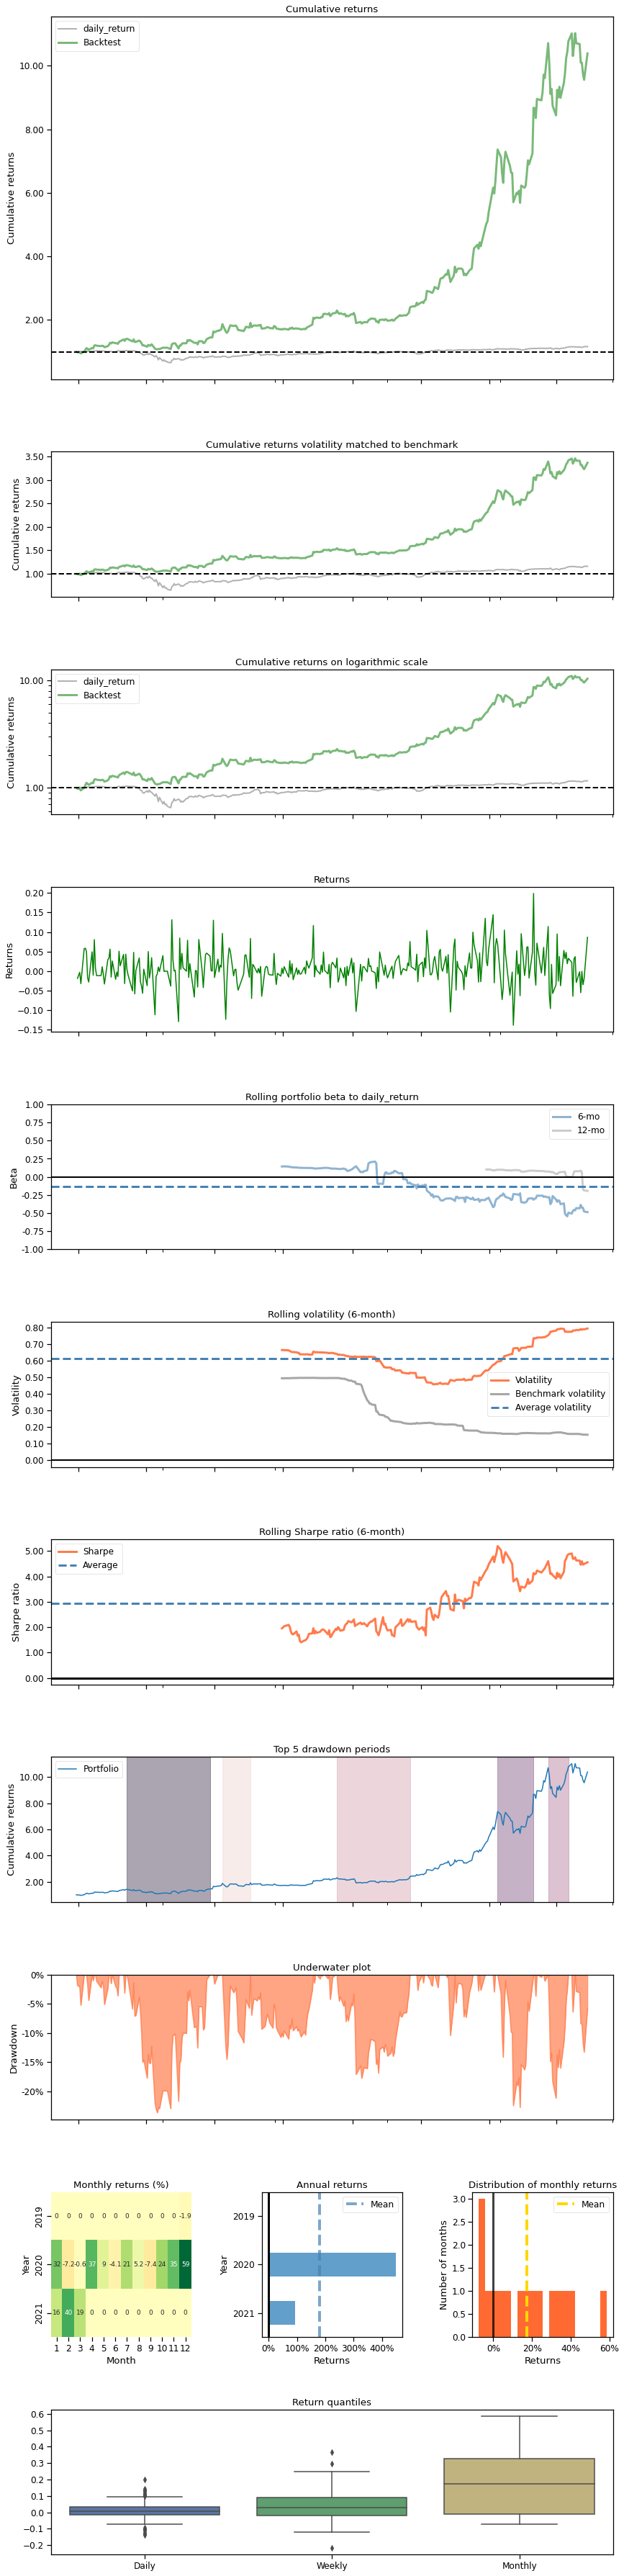

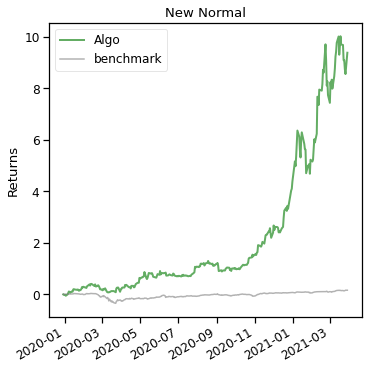

In [83]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])